In [1]:
!git clone https://github.com/aim-hackathon-2020/pump_prediction.git

fatal: destination path 'pump_prediction' already exists and is not an empty directory.



### Problem Solving Strategy

The ideal machine learning project involves general flow analysis stages for building a Predictive Model. Steps followed to perform data analysis:

    Understanding the problem domain
    Data Exploration and Preparation
    Feature Engineering
    Dimensionality Reduction (or Feature Selection)
    Various Model Evaluation and
    Hyper-parameter Tuning
    Ensembling: Model Selection



## STEP 1. Understanding the problem domain

**[Taarifa](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/24/)** is an open source platform for the crowd sourced reporting and triaging of infrastructure related issues. The data for this comeptition comes from the Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water.

**Question:** why not a model to predict if a pump is functional, non-functional, Needs repair based on given parameters?

**List of possible predicting factors:**

*   **Water Source, Quality and the Cost:** What is the water source, water quality, and the water cost?

*   **Consumer Population, Funder and Pump Management:**
    Does it have consumer population enough to get funded?
    Who's funding pump project, management?

*   **Pump Details:**
     What type of pump and its features(construction year, extraction type, water point type ...)? How does the geographic location of the pump infect the status?

## STEP 2. Data Exploration and Preparation

Verified Individual Column values

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
data_labels=pd.read_csv('/content/pump_prediction/data/training_set_values.csv')
data_values=pd.read_csv('/content/pump_prediction/data/training_set_labels.csv')
data_test=pd.read_csv('/content/pump_prediction/data/test_set_values.csv')
data = data_values.merge(data_labels, on='id')
print("Number of Given Records:", data.shape[0])
print("Number of Given Features:", data.shape[1])
print("Test Set Shape: ", data_test.shape)
data.head()

Number of Given Records: 59400
Number of Given Features: 41
Test Set Shape:  (14850, 40)


,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
len(data_test.date_recorded.unique())

331

Number of Given Records: 59400
Number of Given Features: 41


functional                 54.308081
non functional             38.424242
functional needs repair     7.267677
Name: status_group, dtype: float64

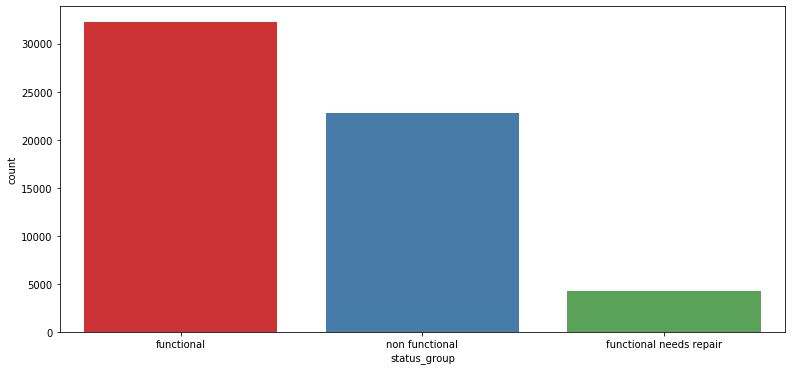

In [5]:
##Target Variable Distribution
print("Number of Given Records:", data.shape[0])
print("Number of Given Features:", data.shape[1])
plt.figure(figsize=(13,6))
sns.countplot(data.status_group, palette = 'Set1')
data["status_group"].value_counts(normalize=True)*100

**Target Class Variable Distribution - (functional, non-functional, Needs repair)**

    Number of Given Records: 59400
    Number of Given Features: 41
    
    functional                 54.308081
    non functional             38.424242
    functional needs repair     7.267677

The target class is imbalanced with functional needs repair being smallest which is approx. 7.26% of whole dataset (59400).

#### 2.1 Exploration, Data Cleaning and Noise Removal

1.   Get rid of unwanted columns ('num_private', 'recorded_by' and unneeded hierarchical columns)
2.   Remove Duplicates if exist
3.   Handle Missing Values, mean, median or mode
4.   Get rid of noise above if any
5. Fix Misrepresented data such as "N,0"" must be addressed, it will be cleaned as a part of data cleaning.

           Before Cleaning: Number of Given Records: 59400
                            Number of Given Features: 41



In [0]:
##Drop Colums which are ids and not useful towards prediction
data.drop(['num_private', 'recorded_by'], axis=1, inplace=True)
data_test.drop(['num_private', 'recorded_by'], axis=1, inplace=True)

In [7]:
data.describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,30500.000000,2013.000000


In [8]:
height_check = data[data['gps_height'] == 0]
print(height_check.groupby(['basin']).size())

basin
Internal                   3109
Lake Nyasa                 2430
Lake Rukwa                 1442
Lake Tanganyika            2811
Lake Victoria              7716
Pangani                     387
Rufiji                     1155
Ruvuma / Southern Coast       6
Wami / Ruvu                1382
dtype: int64


In [9]:
print(data.groupby(['basin']).size())

basin
Internal                    7785
Lake Nyasa                  5085
Lake Rukwa                  2454
Lake Tanganyika             6432
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Ruvuma / Southern Coast     4493
Wami / Ruvu                 5987
dtype: int64


In [10]:
for colm in data.columns:
  print(colm," ", len(data[colm].unique()))

id   59400
status_group   3
amount_tsh   98
date_recorded   356
funder   1898
gps_height   2428
installer   2146
longitude   57516
latitude   57517
wpt_name   37400
basin   9
subvillage   19288
region   21
region_code   27
district_code   20
lga   125
ward   2092
population   1049
public_meeting   3
scheme_management   13
scheme_name   2697
permit   3
construction_year   55
extraction_type   18
extraction_type_group   13
extraction_type_class   7
management   12
management_group   5
payment   7
payment_type   7
water_quality   8
quality_group   6
quantity   5
quantity_group   5
source   10
source_type   7
source_class   3
waterpoint_type   7
waterpoint_type_group   6


In [11]:
for colm in data_test.columns:
  print(colm," ", len(data_test[colm].unique()))

id   14850
amount_tsh   68
date_recorded   331
funder   981
gps_height   2157
installer   1092
longitude   14390
latitude   14390
wpt_name   10840
basin   9
subvillage   8444
region   21
region_code   26
district_code   20
lga   125
ward   1959
population   637
public_meeting   3
scheme_management   12
scheme_name   1790
permit   3
construction_year   55
extraction_type   17
extraction_type_group   13
extraction_type_class   7
management   12
management_group   5
payment   7
payment_type   7
water_quality   8
quality_group   6
quantity   5
quantity_group   5
source   10
source_type   7
source_class   3
waterpoint_type   7
waterpoint_type_group   6


**Note:** longitude, amount_tsh and population are highly skewed and must be taken cared by Normalization.

Almost 50% of population falls in 0 or 1:
```
0 : 35.994949%
1  : 11.826599%
```
Think before considering amount_tsh - this has  0.0  :70.099327%

GPS_heigh - 34.407407%  got 0 height

In [12]:
#SKEW in Data # skewness along the index axis
data['gps_height'].replace(0.0, np.nan, inplace=True)
data['population'].replace(0.0, np.nan, inplace=True)
data['population'].replace("0.0", np.nan, inplace=True)
data['amount_tsh'].replace(0.0, np.nan, inplace=True)
print(data.skew(axis = 0, skipna = True))

id                    0.002623
amount_tsh           32.487610
gps_height           -0.201926
longitude            -4.191046
latitude             -0.152037
region_code           3.173818
district_code         3.962045
population           10.988913
public_meeting       -2.861945
permit               -0.819382
construction_year    -0.634928
dtype: float64


In [13]:
#SKEW in Data # skewness along the index axis
data_test['gps_height'].replace(0.0, np.nan, inplace=True)
data_test['population'].replace(0.0, np.nan, inplace=True)
data_test['amount_tsh'].replace(0.0, np.nan, inplace=True)
print(data_test.skew(axis = 0, skipna = True))

id                   -0.010584
amount_tsh           24.943995
gps_height           -0.179493
longitude            -4.173130
latitude             -0.156238
region_code           3.201174
district_code         3.959339
population            6.965277
public_meeting       -2.823088
permit               -0.827471
construction_year    -0.609383
dtype: float64


Interpreting Skewness: If skewness is less than −1 or greater than +1, the distribution is highly skewed. If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed. If skewness is between −½ and +½, the distribution is approximately symmetric.



### 2.1.1 Water Source: 

In [0]:
#For every categorical response, convert the levels to lower case, in case there is random capitalization
for colm in data.columns:
  if data[colm].dtypes == object:
    data[colm] = data[colm].astype(str).str.lower()

for colm in data_test.columns:
  if data_test[colm].dtypes == object:
    data_test[colm] = data_test[colm].astype(str).str.lower()

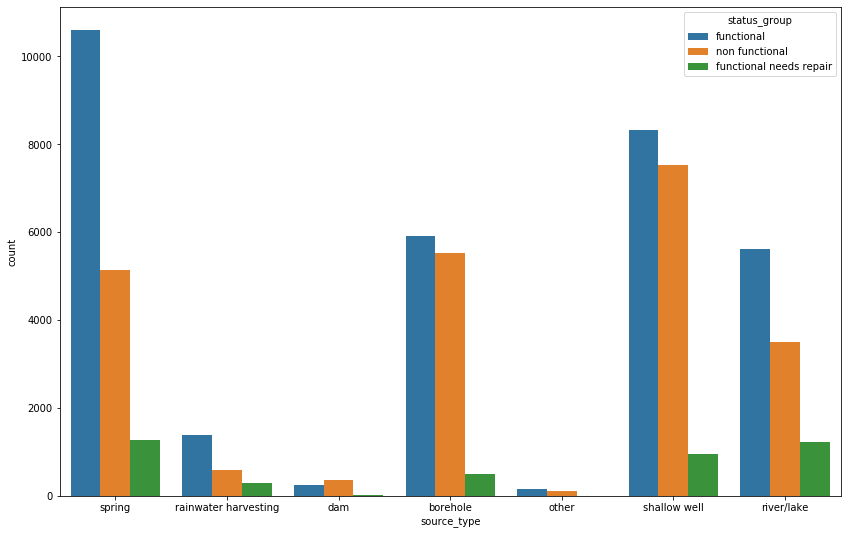

In [15]:
plt.figure(figsize=(14, 9))
sns.countplot(data=data,x='source_type',hue='status_group')

In [16]:
print(data.groupby(['source', 'source_type', 'source_class']).size())
data.drop('source_type',axis=1,inplace=True)
data.drop('source_class',axis=1,inplace=True)
data_test.drop('source_type',axis=1,inplace=True)
data_test.drop('source_class',axis=1,inplace=True)

source                source_type           source_class
dam                   dam                   surface           656
hand dtw              borehole              groundwater       874
lake                  river/lake            surface           765
machine dbh           borehole              groundwater     11075
other                 other                 unknown           212
rainwater harvesting  rainwater harvesting  surface          2295
river                 river/lake            surface          9612
shallow well          shallow well          groundwater     16824
spring                spring                groundwater     17021
unknown               other                 unknown            66
dtype: int64


### 2.1.2. Water Quality, Quantity and Cost: 

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

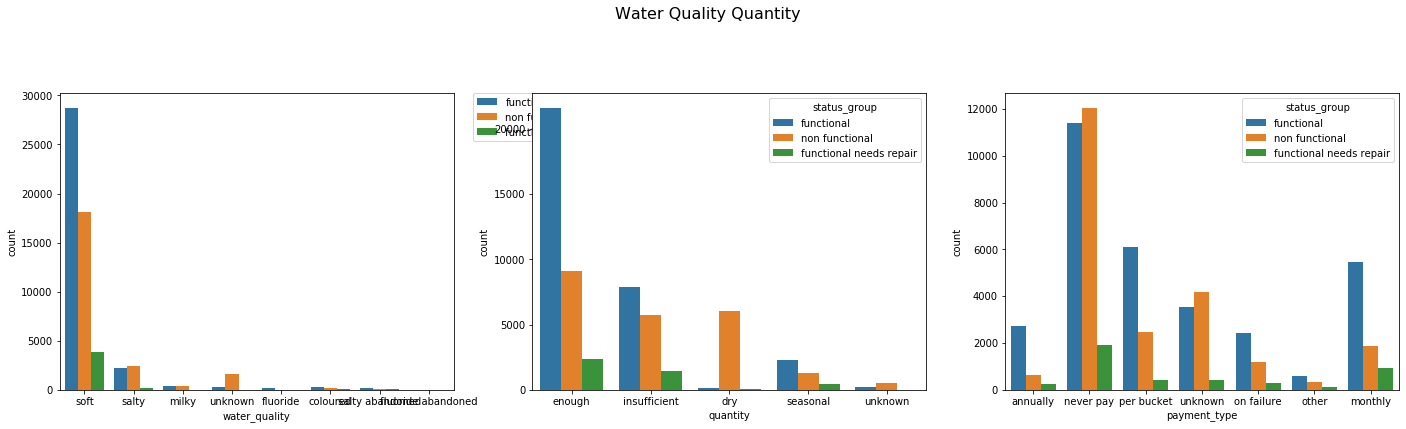

In [17]:
plt.figure(figsize=(24,12))
s_title ='Water Quality Quantity'
plt.suptitle(s_title, fontsize=16)

plt.subplot(2,3,1)

sns.countplot(data=data,x='water_quality',hue='status_group')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(2,3,2)
sns.countplot(data=data,x='quantity',hue='status_group')

plt.subplot(2,3,3)
sns.countplot(data=data,x='payment_type',hue='status_group')

data.water_quality.value_counts()

In above payment barchart, never pay and unknown payment type got many non functional instaances.

In [18]:
print(data.groupby(['water_quality', 'quality_group']).size())
data.drop('quality_group',axis=1,inplace=True)
data_test.drop('quality_group',axis=1,inplace=True)
print(data.groupby(['quantity', 'quantity_group']).size())
data.drop('quantity_group',axis=1,inplace=True)
data_test.drop('quantity_group',axis=1,inplace=True)
print(data.groupby(['payment', 'payment_type']).size())
data.drop('payment',axis=1,inplace=True)
data_test.drop('payment',axis=1,inplace=True)

water_quality       quality_group
coloured            colored            490
fluoride            fluoride           200
fluoride abandoned  fluoride            17
milky               milky              804
salty               salty             4856
salty abandoned     salty              339
soft                good             50818
unknown             unknown           1876
dtype: int64
quantity      quantity_group
dry           dry                6246
enough        enough            33186
insufficient  insufficient      15129
seasonal      seasonal           4050
unknown       unknown             789
dtype: int64
payment                payment_type
never pay              never pay       25348
other                  other            1054
pay annually           annually         3642
pay monthly            monthly          8300
pay per bucket         per bucket       8985
pay when scheme fails  on failure       3914
unknown                unknown          8157
dtype: int64


Text(0, 0.5, 'Probability Density')

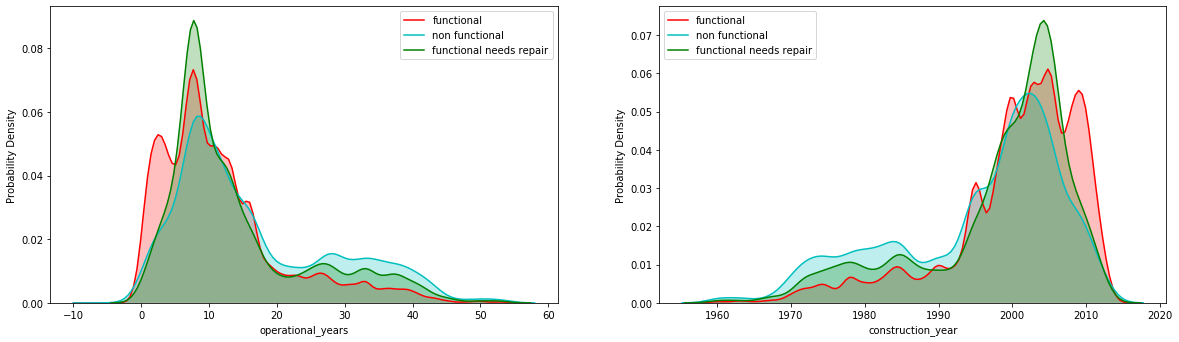

In [19]:
#if water point is old, it is highly likely to be non functional or needs repair.
#New features were created namely number of days and number of months water point is operational.
data['construction_year'].replace(0.0, np.nan, inplace=True)
data["construction_year"].fillna(data.groupby(['region', 'district_code'])["construction_year"].transform("median"), inplace=True)
data["construction_year"].fillna(data.groupby(['region'])["construction_year"].transform("median"), inplace=True)
data["construction_year"].fillna(data.groupby(['district_code'])["construction_year"].transform("median"), inplace=True)
data["construction_year"].fillna(data["construction_year"].median(), inplace=True)

data['date_recorded'] = pd.to_datetime(data['date_recorded'])
data['operational_year'] = data.date_recorded.dt.year - data.construction_year


data_test['construction_year'].replace(0.0, np.nan, inplace=True)
data_test["construction_year"].fillna(data_test.groupby(['region', 'district_code'])["construction_year"].transform("median"), inplace=True)
data_test["construction_year"].fillna(data_test.groupby(['region'])["construction_year"].transform("median"), inplace=True)
data_test["construction_year"].fillna(data_test.groupby(['district_code'])["construction_year"].transform("median"), inplace=True)
data_test["construction_year"].fillna(data_test["construction_year"].median(), inplace=True)

data_test['date_recorded'] = pd.to_datetime(data_test['date_recorded'])
data_test['operational_year'] = data_test.date_recorded.dt.year - data_test.construction_year

# Plotting the KDE Plot 
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.kdeplot(data.loc[(data['status_group']=='functional'), 
            'operational_year'], color='r', shade=True, Label='functional') 
  
sns.kdeplot(data.loc[(data['status_group']=='non functional'),  
            'operational_year'], color='c', shade=True, Label='non functional') 

sns.kdeplot(data.loc[(data['status_group']=='functional needs repair'),  
            'operational_year'], color='g', shade=True, Label='functional needs repair') 
  
plt.xlabel('operational_years') 
plt.ylabel('Probability Density')

plt.subplot(2,2,2)

sns.kdeplot(data.loc[(data['status_group']=='functional'), 
            'construction_year'], color='r', shade=True, Label='functional') 
  
sns.kdeplot(data.loc[(data['status_group']=='non functional'),  
            'construction_year'], color='c', shade=True, Label='non functional') 

sns.kdeplot(data.loc[(data['status_group']=='functional needs repair'),  
            'construction_year'], color='g', shade=True, Label='functional needs repair') 
  
plt.xlabel('construction_year') 
plt.ylabel('Probability Density')

In [0]:
data.drop('construction_year',axis=1,inplace=True)
data.drop('date_recorded',axis=1,inplace=True)

data_test.drop('construction_year',axis=1,inplace=True)
data_test.drop('date_recorded',axis=1,inplace=True)

### 2.1.3. Pump Details and Consumer Population:

Almost 50% of population falls in 0 or 1:
```
0 : 35.994949%
1  : 11.826599%
```
Think before considering amount_tsh - this has  0.0  :70.099327%

GPS_heigh - 34.407407%  got 0 height


Text(0, 0.5, 'Probability Density')

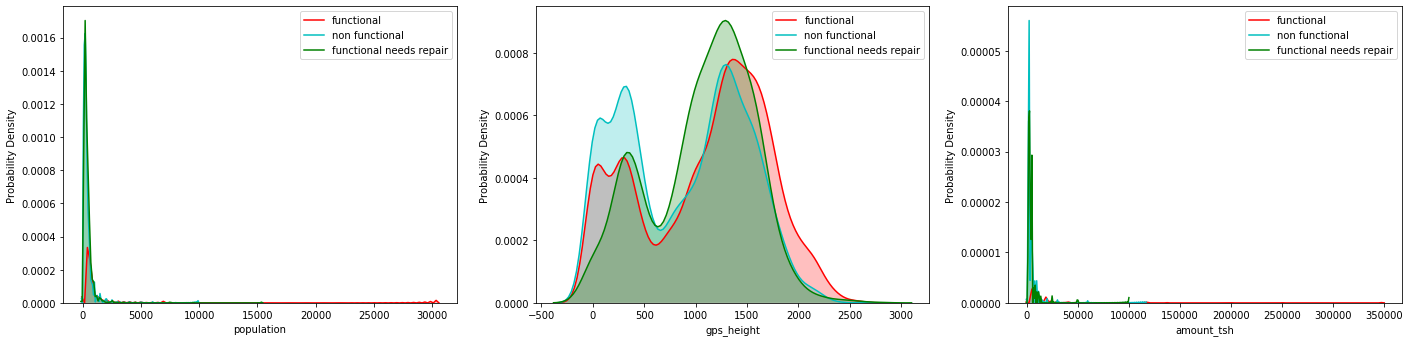

In [21]:
# Plotting the KDE Plot 
plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
sns.kdeplot(data.loc[(data['status_group']=='functional'), 
            'population'], color='r', shade=True, Label='functional') 
  
sns.kdeplot(data.loc[(data['status_group']=='non functional'),  
            'population'], color='c', shade=True, Label='non functional') 

sns.kdeplot(data.loc[(data['status_group']=='functional needs repair'),  
            'population'], color='g', shade=True, Label='functional needs repair') 
  
plt.xlabel('population') 
plt.ylabel('Probability Density')

plt.subplot(2,3,2)

sns.kdeplot(data.loc[(data['status_group']=='functional'), 
            'gps_height'], color='r', shade=True, Label='functional') 
  
sns.kdeplot(data.loc[(data['status_group']=='non functional'),  
            'gps_height'], color='c', shade=True, Label='non functional') 

sns.kdeplot(data.loc[(data['status_group']=='functional needs repair'),  
            'gps_height'], color='g', shade=True, Label='functional needs repair') 
  
plt.xlabel('gps_height') 
plt.ylabel('Probability Density')


plt.subplot(2,3,3)

sns.kdeplot(data.loc[(data['status_group']=='functional'), 
            'amount_tsh'], color='r', shade=True, Label='functional') 
  
sns.kdeplot(data.loc[(data['status_group']=='non functional'),  
            'amount_tsh'], color='c', shade=True, Label='non functional') 

sns.kdeplot(data.loc[(data['status_group']=='functional needs repair'),  
            'amount_tsh'], color='g', shade=True, Label='functional needs repair') 
  
plt.xlabel('amount_tsh') 
plt.ylabel('Probability Density')

A Density Plot visualises the distribution of data over a continuous interval or time period. This chart is a variation of a Histogram that uses kernel smoothing to plot values, allowing for smoother distributions by smoothing out the noise.

In [0]:
test = data

In [0]:
##Fixing Null Values 34.407407%  got 0 height
data["gps_height"].fillna(data.groupby(['region', 'district_code'])["gps_height"].transform("mean"), inplace=True)
data["gps_height"].fillna(data.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
data["gps_height"].fillna(data["gps_height"].mean(), inplace=True)

### Almost 50% 0 or 1
data["population"].fillna(data.groupby(['region', 'district_code'])["population"].transform("median"), inplace=True)
data["population"].fillna(data.groupby(['region'])["population"].transform("median"), inplace=True)
data["population"].fillna(data["population"].median(), inplace=True)

##Think before considering amount_tsh - this has  0.0  :70.099327%
data["amount_tsh"].fillna(data.groupby(['region', 'district_code'])["amount_tsh"].transform("median"), inplace=True)
data["amount_tsh"].fillna(data.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
data["amount_tsh"].fillna(data["amount_tsh"].median(), inplace=True)

##Fixing Null Values 34.407407%  got 0 height
data_test["gps_height"].fillna(data_test.groupby(['region', 'district_code'])["gps_height"].transform("mean"), inplace=True)
data_test["gps_height"].fillna(data_test.groupby(['region'])["gps_height"].transform("mean"), inplace=True)
data_test["gps_height"].fillna(data_test["gps_height"].mean(), inplace=True)

### Almost 50% 0 or 1
data_test["population"].fillna(data_test.groupby(['region', 'district_code'])["population"].transform("median"), inplace=True)
data_test["population"].fillna(data_test.groupby(['region'])["population"].transform("median"), inplace=True)
data_test["population"].fillna(data_test["population"].median(), inplace=True)

##Think before considering amount_tsh - this has  0.0  :70.099327%
data_test["amount_tsh"].fillna(data_test.groupby(['region', 'district_code'])["amount_tsh"].transform("median"), inplace=True)
data_test["amount_tsh"].fillna(data_test.groupby(['region'])["amount_tsh"].transform("median"), inplace=True)
data_test["amount_tsh"].fillna(data_test["amount_tsh"].median(), inplace=True)

In [24]:
data[data['population'] == 0]

,id,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,waterpoint_type,waterpoint_type_group,operational_year


### Recheck with extraction_type_class

In [25]:
print(data.groupby(['extraction_type_group','extraction_type_class','extraction_type']).size()   )   
data.drop('extraction_type_group',axis=1,inplace=True)
data.drop('extraction_type_class',axis=1,inplace=True)

data_test.drop('extraction_type_group',axis=1,inplace=True)
data_test.drop('extraction_type_class',axis=1,inplace=True)

print(data.groupby(['waterpoint_type', 'waterpoint_type_group']).size())
data.drop('waterpoint_type_group',axis=1,inplace=True)
data.drop('wpt_name',axis=1,inplace=True)

data_test.drop('waterpoint_type_group',axis=1,inplace=True)
data_test.drop('wpt_name',axis=1,inplace=True)

extraction_type_group  extraction_type_class  extraction_type          
afridev                handpump               afridev                       1770
gravity                gravity                gravity                      26780
india mark ii          handpump               india mark ii                 2400
india mark iii         handpump               india mark iii                  98
mono                   motorpump              mono                          2865
nira/tanira            handpump               nira/tanira                   8154
other                  other                  other                         6430
other handpump         handpump               other - mkulima/shinyanga        2
                                              other - play pump               85
                                              other - swn 81                 229
                                              walimi                          48
other motorpump        motorpump     

### 2.1.4. Pump Location:

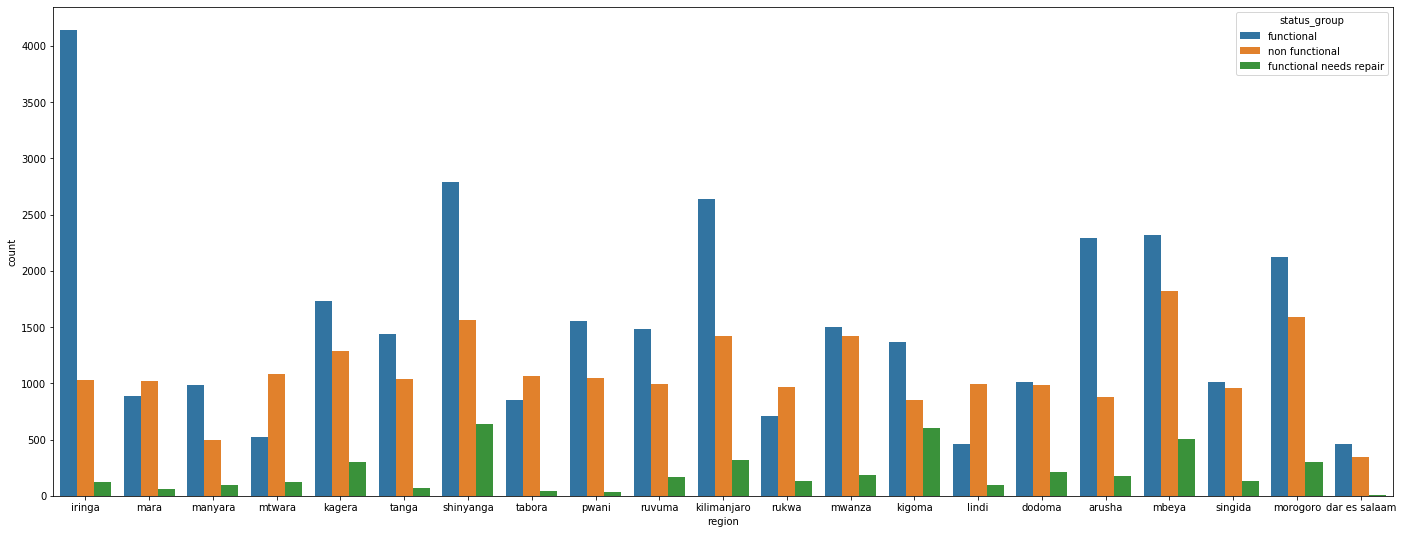

In [26]:
#looking at regions
plt.figure(figsize=(24, 9))
sns.countplot(data=data,x='region',hue='status_group')

### Note: Converting geolocation data into zones

In [0]:
data['longitude'].replace(0.0, np.nan, inplace=True)
data['latitude'].replace(0.0, np.nan, inplace=True)
data["latitude"].fillna(data.groupby(['region', 'district_code'])["latitude"].transform("mean"), inplace=True)
data["longitude"].fillna(data.groupby(['region', 'district_code'])["longitude"].transform("mean"), inplace=True)
data["longitude"].fillna(data.groupby(['region'])["longitude"].transform("mean"), inplace=True)

data_test['longitude'].replace(0.0, np.nan, inplace=True)
data_test['latitude'].replace(0.0, np.nan, inplace=True)
data_test["latitude"].fillna(data_test.groupby(['region', 'district_code'])["latitude"].transform("mean"), inplace=True)
data_test["longitude"].fillna(data_test.groupby(['region', 'district_code'])["longitude"].transform("mean"), inplace=True)
data_test["longitude"].fillna(data_test.groupby(['region'])["longitude"].transform("mean"), inplace=True)

In [28]:
waste_features=['subvillage','region_code']
#since region and region_code are representing the same thing
data.drop(waste_features,axis=1,inplace=True)
data_test.drop(waste_features,axis=1,inplace=True)

print(data.groupby(['lga', 'ward','status_group']).size())
data.drop('ward',axis=1,inplace=True)
data_test.drop('ward',axis=1,inplace=True)

lga           ward     status_group           
arusha rural  bangata  functional                 21
                       functional needs repair     2
                       non functional             10
              bwawani  functional                 12
                       non functional             25
                                                  ..
uyui          ufuluma  non functional             10
              upuge    functional                  7
                       non functional             11
              usagali  functional                  8
                       non functional             17
Length: 5070, dtype: int64


### 2.1.5. Pump Management:

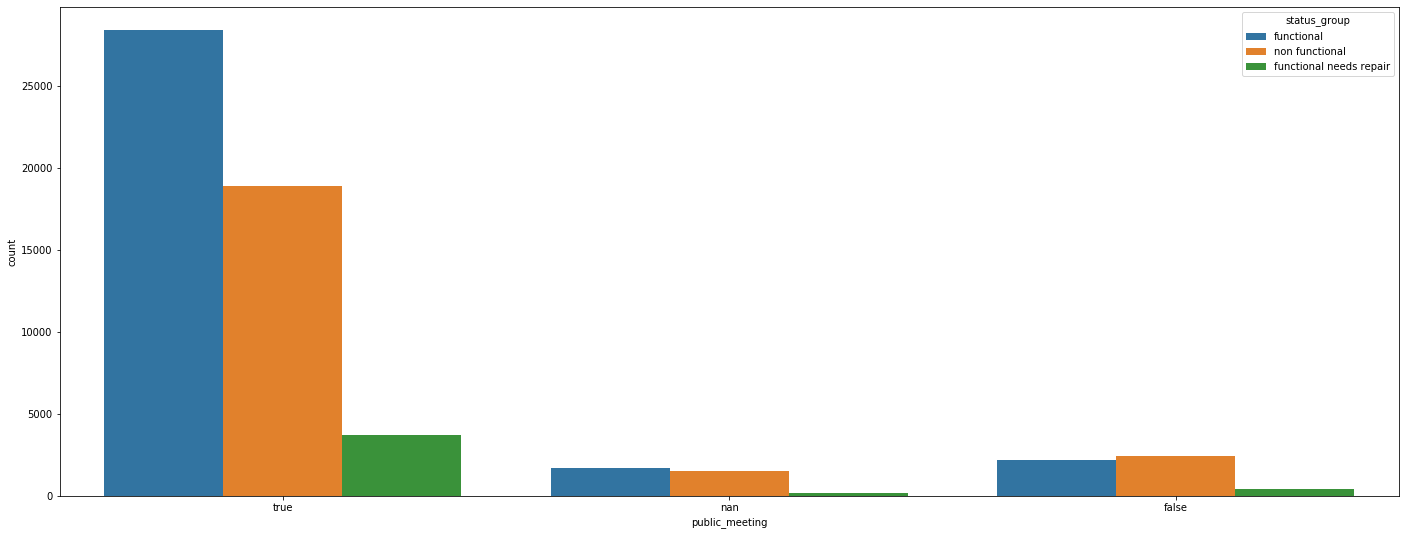

In [29]:
plt.figure(figsize=(24, 9))
sns.countplot(data=data,x='public_meeting',hue='status_group')

In [30]:
data['funder'].replace("0", np.nan, inplace=True)
data['funder'].replace("nan", np.nan, inplace=True)
data['scheme_management'].replace(0, np.nan, inplace=True)
data['scheme_management'].replace("nan", np.nan, inplace=True)
data["funder"].fillna("other", inplace=True)
data["scheme_management"].fillna("other", inplace=True)
data["installer"].fillna("other", inplace=True)

data_test['funder'].replace("0", np.nan, inplace=True)
data_test['funder'].replace("nan", np.nan, inplace=True)
data_test['scheme_management'].replace(0, np.nan, inplace=True)
data_test['scheme_management'].replace("nan", np.nan, inplace=True)
data_test["funder"].fillna("other", inplace=True)
data_test["scheme_management"].fillna("other", inplace=True)
data_test["installer"].fillna("other", inplace=True)


print(data.groupby(['management', 'management_group']).size() )
data.drop('management_group',axis=1,inplace=True)
data_test.drop('management_group',axis=1,inplace=True)

print(data.groupby(['scheme_management', 'scheme_name']).size())
data.drop('scheme_name',axis=1,inplace=True)
data_test.drop('scheme_name',axis=1,inplace=True)

print(data.groupby(['installer', 'funder','status_group']).size())
data.drop('installer',axis=1,inplace=True)
data.drop('public_meeting', axis=1, inplace=True)
data.drop('permit', axis=1, inplace=True)

data_test.drop('installer',axis=1,inplace=True)
data_test.drop('public_meeting', axis=1, inplace=True)
data_test.drop('permit', axis=1, inplace=True)

management        management_group
company           commercial            685
other             other                 844
other - school    other                  99
parastatal        parastatal           1768
private operator  commercial           1971
trust             commercial             78
unknown           unknown               561
vwc               user-group          40507
water authority   commercial            904
water board       user-group           2933
wua               user-group           2535
wug               user-group           6515
dtype: int64
scheme_management  scheme_name                     
company            bagamoyo wate                       270
                   bffs                                  1
                   borehole                              1
                   borehole drilling project             1
                   bulamba piped scheme                  2
                                                      ... 
wug               

In [35]:
features=['amount_tsh', 'gps_height', 'population']
scaler = MinMaxScaler(feature_range=(0,20))
data[features] = scaler.fit_transform(data[features])
data_test[features] = scaler.fit_transform(data_test[features])
data[features].head(5)

,amount_tsh,gps_height,population
0,0.342846,10.349650,0.070822
1,0.011417,10.412587,0.182957
2,0.001417,5.426573,0.163284
3,0.002846,2.468531,0.037378
4,0.014274,8.024794,0.130496


In [36]:
print(data.isnull().sum())
print(data.isna().sum())
data.info()
data.quantity.head(5)
pd.DataFrame(data).to_csv("clean.csv", index=False)

id                   0
status_group         0
amount_tsh           0
funder               0
gps_height           0
longitude            0
latitude             0
basin                0
region               0
district_code        0
lga                  0
population           0
scheme_management    0
extraction_type      0
management           0
payment_type         0
water_quality        0
quantity             0
source               0
waterpoint_type      0
operational_year     0
dtype: int64
id                   0
status_group         0
amount_tsh           0
funder               0
gps_height           0
longitude            0
latitude             0
basin                0
region               0
district_code        0
lga                  0
population           0
scheme_management    0
extraction_type      0
management           0
payment_type         0
water_quality        0
quantity             0
source               0
waterpoint_type      0
operational_year     0
dtype: int64
<class '

In [37]:
data[data['population'] == 0.0]

,id,status_group,amount_tsh,funder,gps_height,longitude,latitude,basin,region,district_code,lga,population,scheme_management,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,operational_year
5,9944,functional,0.001131,mkinga distric coun,5.356490,39.172796,-4.765587,pangani,tanga,8,mkinga,0.0,vwc,submersible,vwc,per bucket,salty,enough,other,communal standpipe multiple,2.0
13,50495,functional,0.001131,lawatefuka water supply,10.195804,37.092574,-3.181783,pangani,kilimanjaro,7,siha,0.0,water board,gravity,water board,monthly,soft,enough,spring,communal standpipe,4.0
19,18274,functional,0.028560,danida,12.958042,34.508967,-9.894412,lake nyasa,iringa,5,ludewa,0.0,vwc,gravity,vwc,annually,soft,enough,spring,communal standpipe,19.0
28,19685,non functional,0.571417,government of tanzania,10.720280,37.611126,-3.263526,pangani,kilimanjaro,1,rombo,0.0,company,gravity,company,monthly,soft,insufficient,spring,communal standpipe,13.0
29,69124,functional,0.001131,lawatefuka water supply,9.412587,37.061688,-3.191989,pangani,kilimanjaro,7,siha,0.0,water board,gravity,water board,monthly,soft,enough,spring,communal standpipe,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59355,9406,non functional,0.114274,no,12.286713,31.157624,-7.740882,lake rukwa,rukwa,3,nkasi,0.0,vwc,india mark ii,vwc,unknown,unknown,enough,machine dbh,hand pump,26.0
59357,46563,non functional,0.002846,other,12.062937,34.971841,-5.098362,internal,singida,2,singida rural,0.0,vwc,nira/tanira,vwc,unknown,unknown,dry,shallow well,hand pump,33.0
59370,14796,functional,0.011417,other,8.699301,30.058731,-4.902633,lake tanganyika,kigoma,2,kasulu,0.0,other,other,unknown,monthly,unknown,unknown,unknown,other,15.0
59376,34716,non functional,0.002846,other,11.685315,34.821039,-5.076258,internal,singida,2,singida rural,0.0,vwc,other,vwc,unknown,unknown,dry,shallow well,other,23.0


In [38]:
print(data_test.isnull().sum())
data_test.info()
data_test.quantity.head(5)
pd.DataFrame(data_test).to_csv("clean_test.csv", index=False)

id                   0
amount_tsh           0
funder               0
gps_height           0
longitude            0
latitude             0
basin                0
region               0
district_code        0
lga                  0
population           0
scheme_management    0
extraction_type      0
management           0
payment_type         0
water_quality        0
quantity             0
source               0
waterpoint_type      0
operational_year     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 20 columns):
id                   14850 non-null int64
amount_tsh           14850 non-null float64
funder               14850 non-null object
gps_height           14850 non-null float64
longitude            14850 non-null float64
latitude             14850 non-null float64
basin                14850 non-null object
region               14850 non-null object
district_code        14850 non-null int64
lga                  14850 no